# Data Preprocessing and EDA

#### Import libraries

In [63]:
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.getcwd()

'c:\\Users\\amman\\Documents\\MLOPS\\Youtube-Sentiment-Insights\\notebooks'

In [3]:
os.chdir("../")
os.getcwd()

'c:\\Users\\amman\\Documents\\MLOPS\\Youtube-Sentiment-Insights'

#### Load the Data

In [64]:
df = pd.read_csv(r"data\youtube_comment_sentiment.csv")
df.head()

,text,label
0,Anyone know what movie this is?,Neutral
1,The fact they're holding each other back while...,Positive
2,waiting next video will be?,Neutral
3,Thanks for the great video.\n\nI don't underst...,Neutral
4,Good person helping good people.\nThis is how ...,Positive


##### Check for missing values

In [65]:
df.isna().sum()

text     0
label    0
dtype: int64

##### Check for duplicates

In [66]:
duplicates = df.duplicated(subset=['text'])
df[duplicates].head(10)

,text,label
601,Nice,Positive
662,awesome,Positive
1645,thanks,Positive
1787,1,Positive
1796,❤,Positive
1797,❤,Positive
2279,1,Neutral
2338,❤,Neutral
2374,Ai,Neutral
2497,Thanks!,Positive


In [67]:
df[duplicates].shape

(42344, 2)

In [68]:
#drop duplicates
df = df.drop_duplicates(subset=['text'], keep='first')
df.shape

(989881, 2)

##### Dataset info

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989881 entries, 0 to 1032224
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    989881 non-null  object
 1   label   989881 non-null  object
dtypes: object(2)
memory usage: 22.7+ MB


In [70]:
df.describe()

,text,label
count,989881,989881
unique,989881,3
top,Why no rust?,Negative
freq,1,339489


##### Check label value counts

<Axes: xlabel='label'>

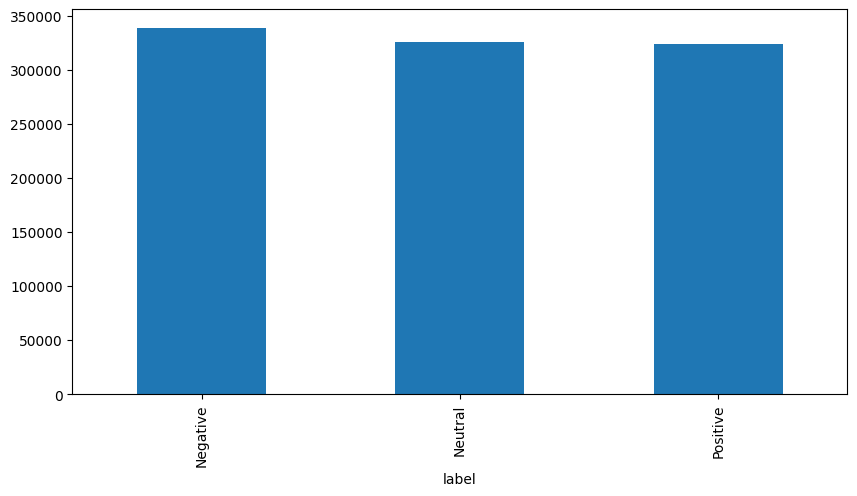

In [101]:
df['label'].value_counts().plot(kind='bar', figsize=(10, 5))

The dataset is well balanced

##### Check if there are non-english comments and comments with emojis

In [71]:
# Check for comments that are not in English and contain emojis
import emoji
from collections import Counter
import re
from tqdm import tqdm


In [72]:
tqdm.pandas()

def is_likely_english(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return False
    text_ascii = sum(1 for c in text if ord(c) < 128)
    return text_ascii / len(text) > 0.8  # At least 80% ASCII


In [73]:
# Filter non-English comments
df['is_english'] = df['text'].apply(is_likely_english)
df_en = df[df['is_english']]

In [74]:
df[df['is_english'] == False].head(10)

,text,label,is_english
33,🥶🤣,Neutral,False
50,😢,Negative,False
76,Brilhant ❤❤❤❤❤,Positive,False
88,❤,Positive,False
111,经济越差坐公交的人只会更多,Negative,False
117,She.🎉,Neutral,False
129,You are the beeeeeeest🎉🎉🎉🎉🎉🎉,Positive,False
143,Real 😭🙏,Negative,False
151,Nice ❤❤❤,Positive,False
153,BMW 😴,Neutral,False


Since some comments that are english contain emojis, they are being flagged as non-english. Let's deal with emojis first then filter for non-english comments

In [75]:
df.drop(columns=['is_english'], inplace=True)

In [76]:
del df_en

In [77]:
df

,text,label
0,Anyone know what movie this is?,Neutral
1,The fact they're holding each other back while...,Positive
2,waiting next video will be?,Neutral
3,Thanks for the great video.\n\nI don't underst...,Neutral
4,Good person helping good people.\nThis is how ...,Positive
...,...,...
1032219,me here just to read peoples comments about th...,Neutral
1032220,Any recommendations for how to build on top of...,Positive
1032221,"Act foolishly, receive foolish rewards.",Negative
1032222,I think many people would like to know the mod...,Neutral


In [78]:
# Function to extract emojis
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]


In [79]:
# Add column for emojis
df['emojis'] = df['text'].apply(extract_emojis)
df['has_emoji'] = df['emojis'].apply(lambda x: len(x) > 0)

# Emoji usage stats
emoji_comments = df[df['has_emoji']]
emoji_counter = Counter([e for emojis in emoji_comments['emojis'] for e in emojis])

print(f"\nNumber of comments with emojis: {len(emoji_comments)}")
print(f"Top 10 most common emojis:")
for emoji_char, count in emoji_counter.most_common(10):
    print(f"{emoji_char} : {count}")



Number of comments with emojis: 198210
Top 10 most common emojis:
😂 : 108519
❤ : 89731
😢 : 25781
😭 : 20896
🙏 : 18966
🤣 : 18164
😊 : 17414
😅 : 17078
🎉 : 15203
💀 : 13196


About 20% of the comments contain emojis. Instead of completely discarding comments with emojis, we will use the emoji library to convert the emojis to the word representations and then save the dataset for later use.

In [80]:
df

,text,label,emojis,has_emoji
0,Anyone know what movie this is?,Neutral,[],False
1,The fact they're holding each other back while...,Positive,"[😂, 😂]",True
2,waiting next video will be?,Neutral,[],False
3,Thanks for the great video.\n\nI don't underst...,Neutral,[],False
4,Good person helping good people.\nThis is how ...,Positive,[],False
...,...,...,...,...
1032219,me here just to read peoples comments about th...,Neutral,[],False
1032220,Any recommendations for how to build on top of...,Positive,[],False
1032221,"Act foolishly, receive foolish rewards.",Negative,[],False
1032222,I think many people would like to know the mod...,Neutral,[],False


We need to convert the emojis to text (demojize) so they can be passed to the model.

In [82]:
# Convert emojis to text
def convert_emojis_to_text(text):
    return emoji.demojize(text, language='en')

# Create a new column with demojized text
df['demojized_text'] = df['text'].apply(convert_emojis_to_text)

In [83]:
df

,text,label,emojis,has_emoji,demojized_text
0,Anyone know what movie this is?,Neutral,[],False,Anyone know what movie this is?
1,The fact they're holding each other back while...,Positive,"[😂, 😂]",True,The fact they're holding each other back while...
2,waiting next video will be?,Neutral,[],False,waiting next video will be?
3,Thanks for the great video.\n\nI don't underst...,Neutral,[],False,Thanks for the great video.\n\nI don't underst...
4,Good person helping good people.\nThis is how ...,Positive,[],False,Good person helping good people.\nThis is how ...
...,...,...,...,...,...
1032219,me here just to read peoples comments about th...,Neutral,[],False,me here just to read peoples comments about th...
1032220,Any recommendations for how to build on top of...,Positive,[],False,Any recommendations for how to build on top of...
1032221,"Act foolishly, receive foolish rewards.",Negative,[],False,"Act foolishly, receive foolish rewards."
1032222,I think many people would like to know the mod...,Neutral,[],False,I think many people would like to know the mod...


In [84]:
columns_to_keep = ['demojized_text', 'label']
df_demojized = df[columns_to_keep].copy()
df_demojized.columns = ['text', 'label']
df_demojized.head()

,text,label
0,Anyone know what movie this is?,Neutral
1,The fact they're holding each other back while...,Positive
2,waiting next video will be?,Neutral
3,Thanks for the great video.\n\nI don't underst...,Neutral
4,Good person helping good people.\nThis is how ...,Positive


Now we can filter out for non-english comments

In [86]:
df['is_english'] = df['demojized_text'].progress_apply(is_likely_english)


100%|██████████| 989881/989881 [00:18<00:00, 53836.78it/s]


In [87]:
df[df['is_english'] == False].head(10)

,text,label,emojis,has_emoji,demojized_text,is_english
111,经济越差坐公交的人只会更多,Negative,[],False,经济越差坐公交的人只会更多,False
327,아이 씩ㅋㅋㅋ\n저항없이 터짐ㅋㅋㅋ,Positive,[],False,아이 씩ㅋㅋㅋ\n저항없이 터짐ㅋㅋㅋ,False
355,दीदी जोड़ी कोडिंग सीखना चाहती हो हो तो कॉलेज म...,Negative,[],False,दीदी जोड़ी कोडिंग सीखना चाहती हो हो तो कॉलेज म...,False
389,В коробке сидят работники?,Neutral,[],False,В коробке сидят работники?,False
418,最嚴重是消防栓沒水，另外就是保險取消火險，絕對是制度性崩壞，州長市長必須負責任，刑事責任！,Negative,[],False,最嚴重是消防栓沒水，另外就是保險取消火險，絕對是制度性崩壞，州長市長必須負責任，刑事責任！,False
519,خليك مع ايران,Negative,[],False,خليك مع ايران,False
569,Пачему эе нее застрелили,Neutral,[],False,Пачему эе нее застрелили,False
581,На все ваши вопросы ответ один- это Россия…Пра...,Negative,[],False,На все ваши вопросы ответ один- это Россия…Пра...,False
670,北方領土は我が国が降伏寸前に\nソ連が日本との条約を破棄して攻めてきました。我々はこの出来事...,Neutral,[],False,北方領土は我が国が降伏寸前に\nソ連が日本との条約を破棄して攻めてきました。我々はこの出来事...,False
695,感謝您的報導，烏克蘭要幫忙滅火 ，應該有感美國的幫忙，這就是互助，也是美德ㄧ樁,Positive,[],False,感謝您的報導，烏克蘭要幫忙滅火 ，應該有感美國的幫忙，這就是互助，也是美德ㄧ樁,False


In [88]:
df[df['is_english'] == False].shape

(16189, 6)

It seems the filter is performing much better now that we have dealt with emojis first.

In [89]:
# Drop non-English comments
df_en = df[df['is_english']]
df_en = df_en.drop(columns=['is_english'])
df_en.head()

,text,label,emojis,has_emoji,demojized_text
0,Anyone know what movie this is?,Neutral,[],False,Anyone know what movie this is?
1,The fact they're holding each other back while...,Positive,"[😂, 😂]",True,The fact they're holding each other back while...
2,waiting next video will be?,Neutral,[],False,waiting next video will be?
3,Thanks for the great video.\n\nI don't underst...,Neutral,[],False,Thanks for the great video.\n\nI don't underst...
4,Good person helping good people.\nThis is how ...,Positive,[],False,Good person helping good people.\nThis is how ...


We will now just keep demojized_text and label columns

In [106]:
columns_to_keep = ['demojized_text', 'label']
df_cleaned = df_en[columns_to_keep].copy()
df_cleaned.rename(columns={'demojized_text': 'text'}, inplace=True)
df_cleaned.shape

(973692, 2)

In [108]:
df_cleaned.head()

,text,label
0,Anyone know what movie this is?,Neutral
1,The fact they're holding each other back while...,Positive
2,waiting next video will be?,Neutral
3,Thanks for the great video.\n\nI don't underst...,Neutral
4,Good person helping good people.\nThis is how ...,Positive


Lastly, we'll convert labels to integers

In [109]:
# convert label to integers
df_cleaned['label'] = df_cleaned['label'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})
df_cleaned.head()

,text,label
0,Anyone know what movie this is?,0
1,The fact they're holding each other back while...,1
2,waiting next video will be?,0
3,Thanks for the great video.\n\nI don't underst...,0
4,Good person helping good people.\nThis is how ...,1


In [110]:
df_cleaned['label'].value_counts()

label
-1    333868
 1    320002
 0    319822
Name: count, dtype: int64

##### Remove leading or trailing spaces and remove multiple spaces

In [111]:
# Check for leading and trailing spaces in text
df_cleaned['text'] = df_cleaned['text'].str.strip()
# Remove multiple spaces
df_cleaned['text'] = df_cleaned['text'].str.replace(r'\s+', ' ', regex=True)


##### Remove new line characters

In [112]:
# Remove new lines and tabs
df_cleaned['text'] = df_cleaned['text'].str.replace('\n', ' ', regex=True)
df_cleaned['text'] = df_cleaned['text'].str.replace('\t', ' ', regex=True)


### Word Count vs Sentiment

Let's see if positive, negative and neutral comments have common word count frequencies

In [114]:
df_cleaned['word_count'] = df_cleaned['text'].apply(lambda x: len(x.split()))

In [115]:
df_cleaned['word_count'].describe()
     

count    973692.000000
mean         19.948359
std          30.152160
min           1.000000
25%           7.000000
50%          12.000000
75%          23.000000
max        1796.000000
Name: word_count, dtype: float64

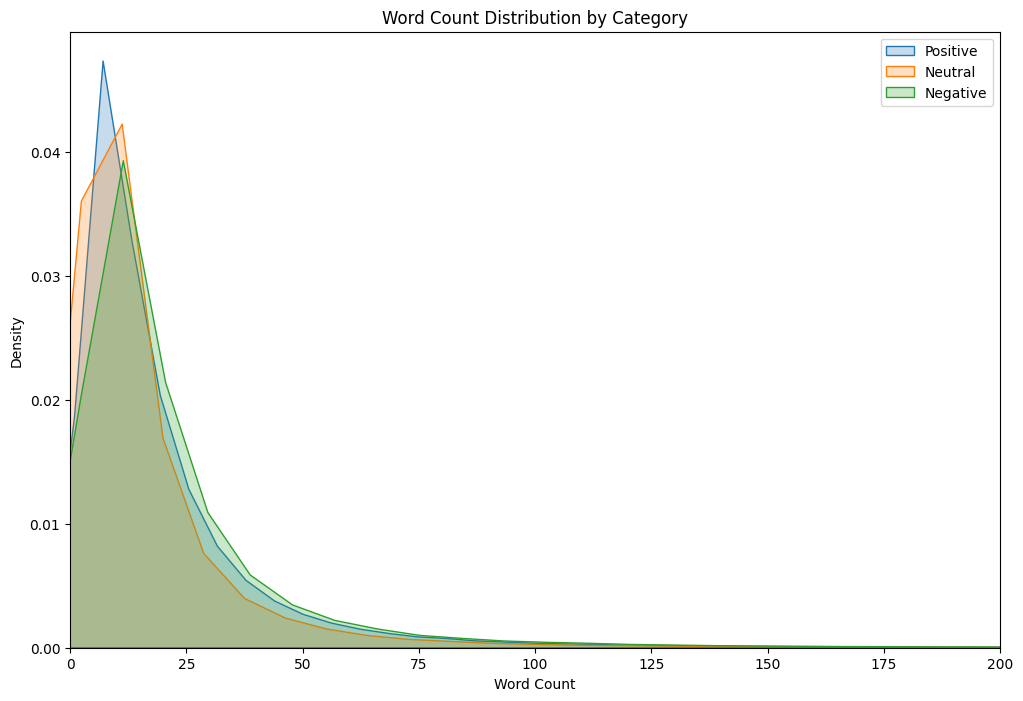

In [119]:

# Create the figure and axes
plt.figure(figsize=(12,8))

# Plot KDE for category 1
sns.kdeplot(df_cleaned[df_cleaned['label'] == 1]['word_count'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df_cleaned[df_cleaned['label'] == 0]['word_count'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df_cleaned[df_cleaned['label'] == -1]['word_count'], label='Negative', fill=True)

# Add title and labels
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.xlim(0, 200)  # Set x-axis limit to 100 words

# Add a legend
plt.legend()

# Show the plot
plt.show()

<Axes: xlabel='label', ylabel='word_count'>

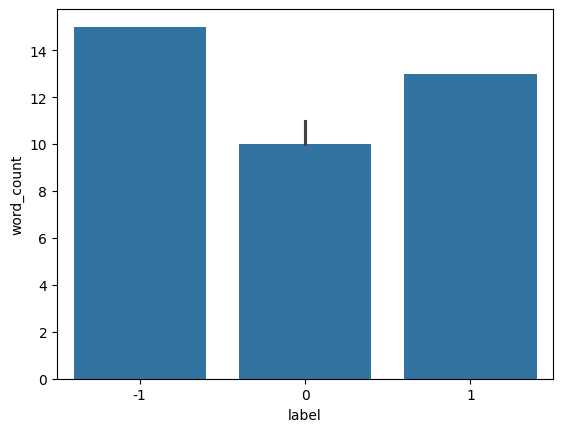

In [120]:
# median word counts among sentiments
sns.barplot(df_cleaned,x='label',y='word_count',estimator='median')

It seems that negative comments tend to have a slightly bigger word count compared to positive comments. Netural comments tend to have the smallest word counts

#### Stop words vs Sentiment

In [121]:
from nltk.corpus import stopwords

# Download NLTK stopwords
import nltk
nltk.download('stopwords')

# Define the list of English stopwords
stop_words = set(stopwords.words('english'))

# Create a new column 'num_stop_words' by counting the number of stopwords in each comment
df_cleaned['num_stop_words'] = df_cleaned['text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amman\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [122]:
df_cleaned.sample(5)

,text,label,word_count,num_stop_words
167423,"BBC News oh dear, trying to copy DW and France...",-1,18,3
10468,:dog:,0,1,0
597548,Sabi ng kapatid ko walang matatanggap ang mga ...,-1,15,0
776930,Kamala Harris is not competent enough to run t...,-1,16,5
763119,"Pausing the video for a second, when you descr...",1,139,61


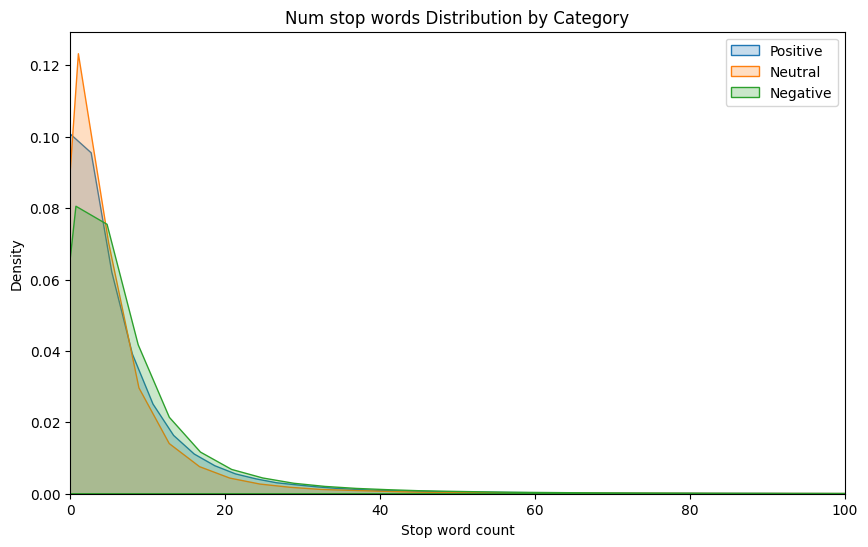

In [124]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df_cleaned[df_cleaned['label'] == 1]['num_stop_words'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df_cleaned[df_cleaned['label'] == 0]['num_stop_words'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df_cleaned[df_cleaned['label'] == -1]['num_stop_words'], label='Negative', fill=True)

# Add title and labels
plt.title('Num stop words Distribution by Category')
plt.xlabel('Stop word count')
plt.ylabel('Density')

plt.xlim(0, 100)  # Set x-axis limit to 100 stop words

# Add a legend
plt.legend()

# Show the plot
plt.show()

<Axes: xlabel='label', ylabel='num_stop_words'>

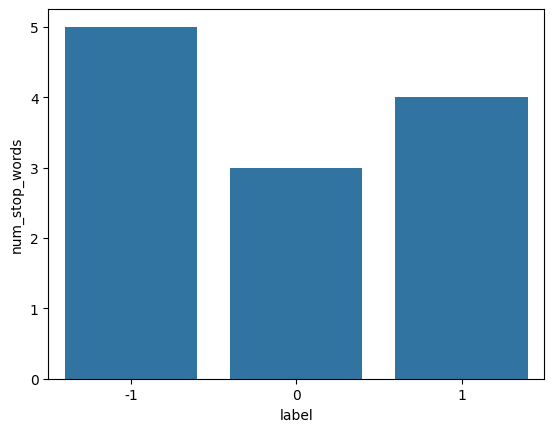

In [125]:
# median stop word counts among sentiments
sns.barplot(df_cleaned,x='label',y='num_stop_words',estimator='median')

Seems like there isn't a huge difference in stop word count between sentiments.

C:\Users\amman\AppData\Local\Temp\ipykernel_1828\2635021115.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')


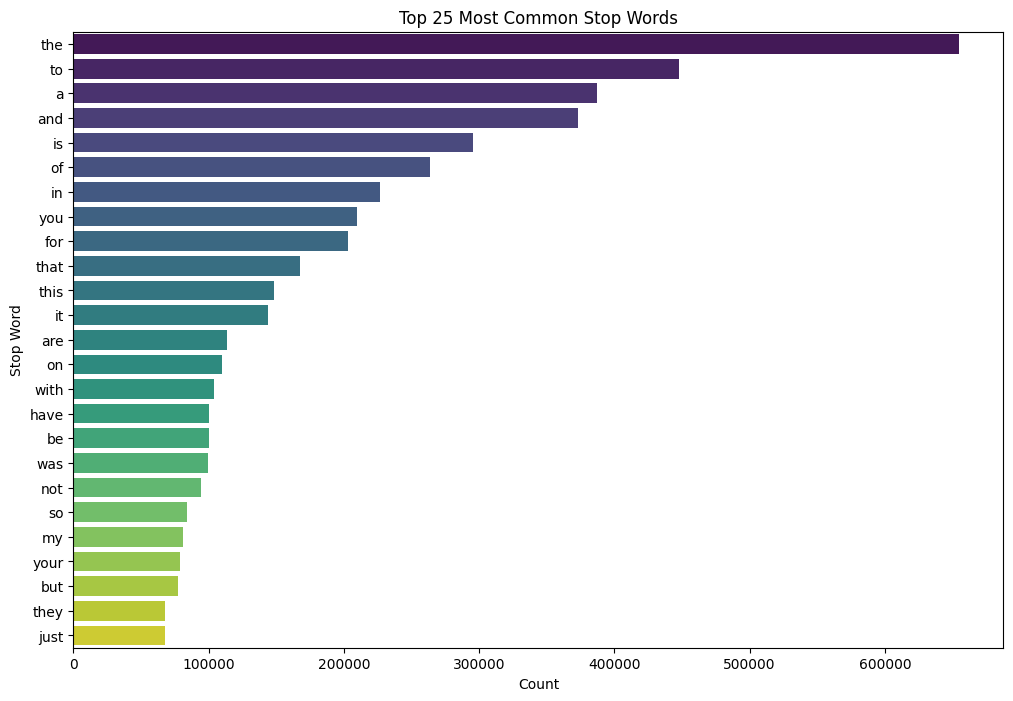

In [126]:
# Create a frequency distribution of stop words in text
from collections import Counter

# Extract all stop words from the comments using the previously defined stop_words
all_stop_words = [word for comment in df_cleaned['text'] for word in comment.split() if word in stop_words]

# Count the most common stop words
most_common_stop_words = Counter(all_stop_words).most_common(25)

# Convert the most common stop words to a DataFrame for plotting
top_25_df = pd.DataFrame(most_common_stop_words, columns=['stop_word', 'count'])

# Create the barplot for the top 25 most common stop words
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')
plt.title('Top 25 Most Common Stop Words')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()


#### Get most common Bigrams in text

C:\Users\amman\AppData\Local\Temp\ipykernel_1828\2318109665.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


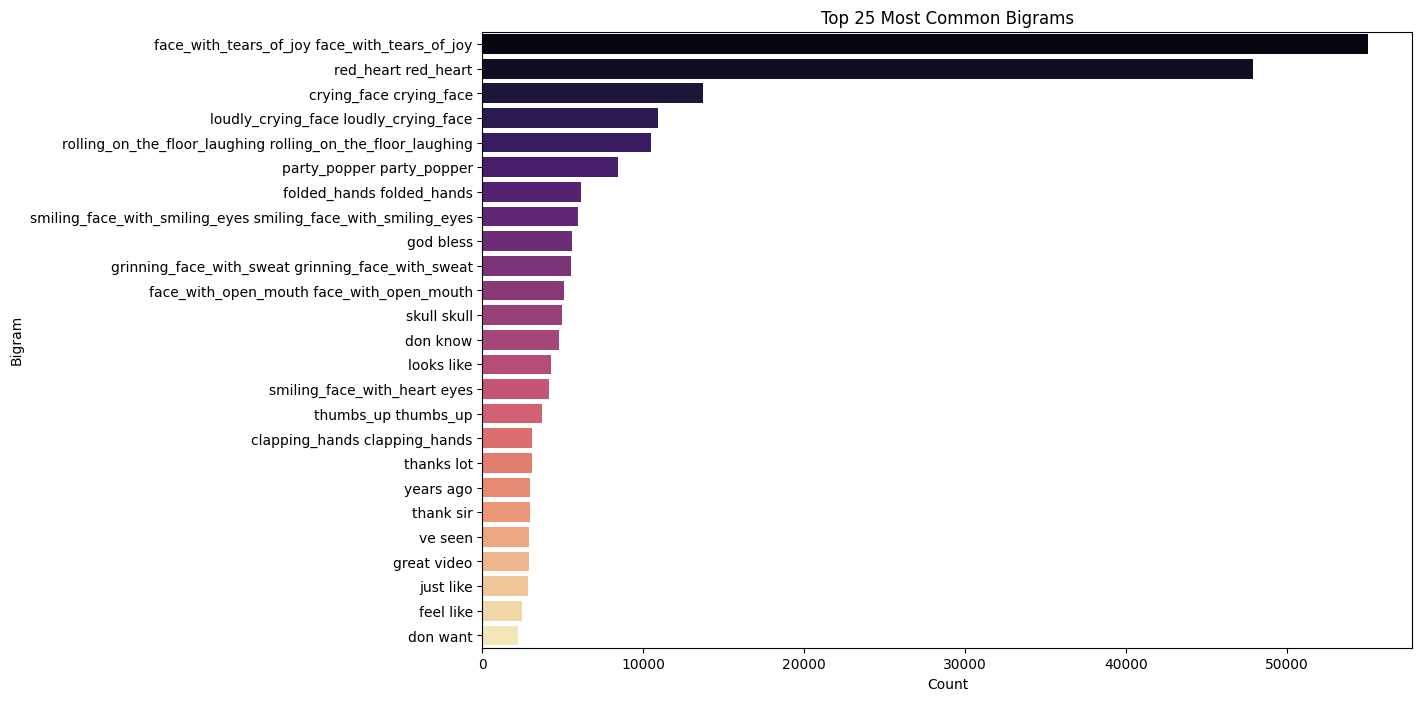

In [130]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a function to extract the top 25 bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 bigrams
top_25_bigrams = get_top_ngrams(df_cleaned['text'], 25)

# Convert the bigrams into a DataFrame for plotting
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot the countplot for the top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

C:\Users\amman\AppData\Local\Temp\ipykernel_1828\2176479704.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')


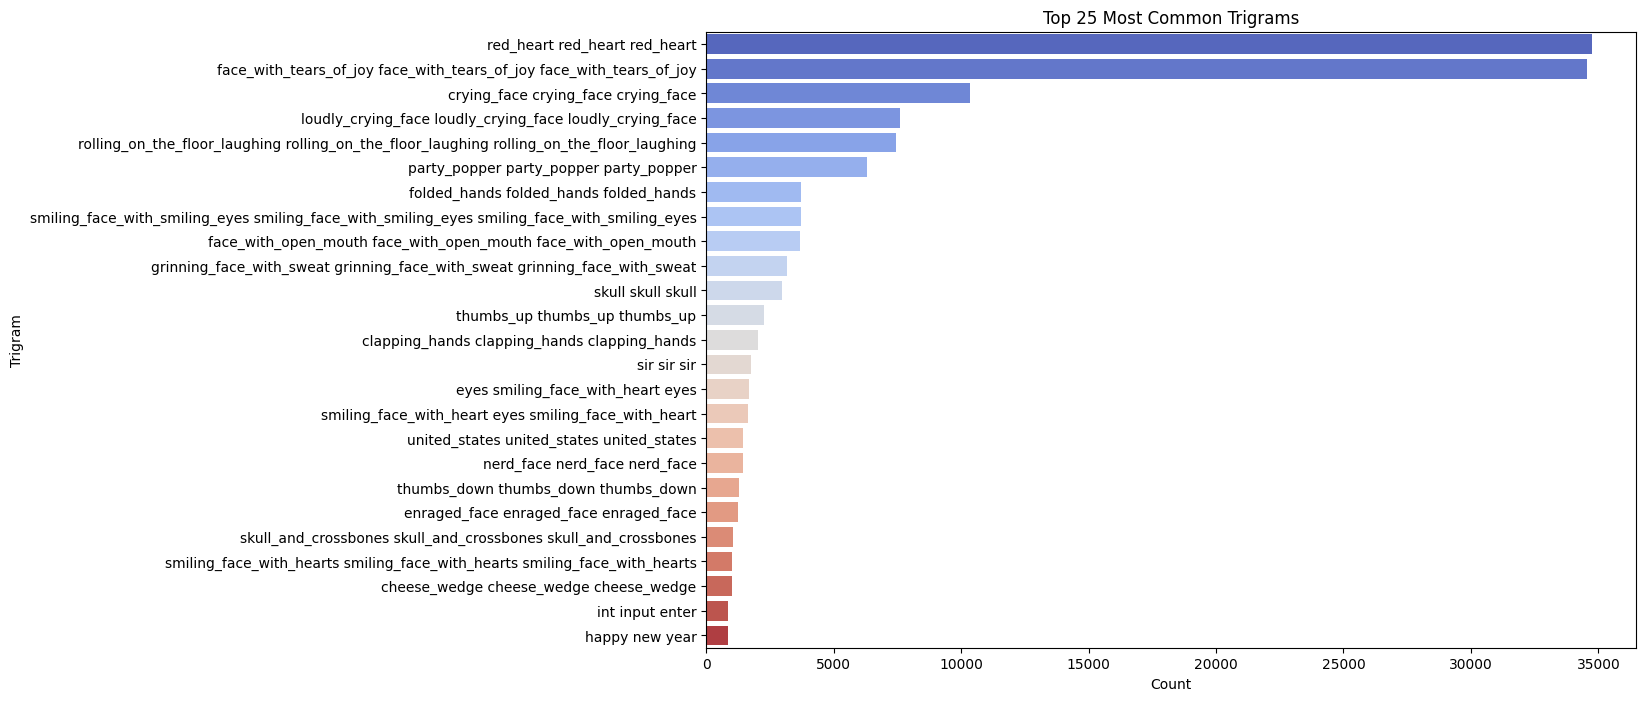

In [131]:
# Create a function to extract the top 25 trigrams
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 trigrams
top_25_trigrams = get_top_trigrams(df_cleaned['text'], 25)

# Convert the trigrams into a DataFrame for plotting
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot the countplot for the top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

Seems like repeating emojis are very common in the Youtube comments

#### Remove Stopwords

In [138]:
from nltk.corpus import stopwords

# Defining stop words but keeping essential ones for sentiment analysis
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Remove stop words from text column, retaining essential ones
df_cleaned['text'] = df_cleaned['text'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)



#### Apply Lemmatization

In [139]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'clean_comment_no_stopwords' column
df_cleaned['text'] = df_cleaned['text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df_cleaned.head()
     

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,label,word_count,num_stop_words
0,Anyone know movie is?,0,6,2
1,fact holding back equally aggressive :face_wit...,1,13,6
2,waiting next video be?,0,5,1
3,Thanks great video. understand DB continues ac...,0,91,43
4,Good person helping good people. America excep...,1,19,9


#### Word Clouds

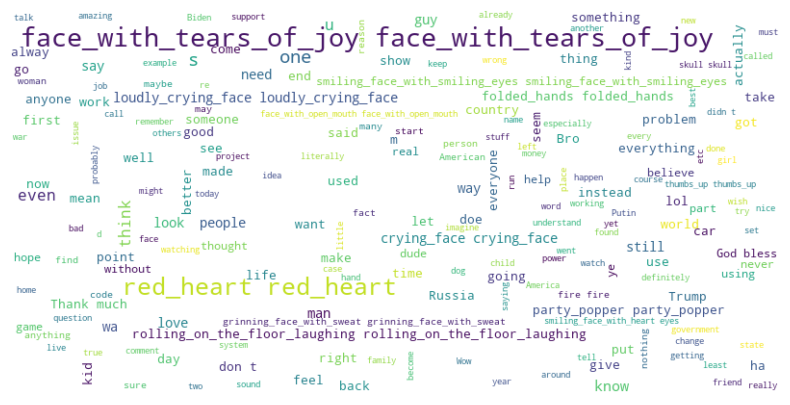

In [140]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df_cleaned['text'])

Let's see a word cloud for each sentiment type

##### Postive comments

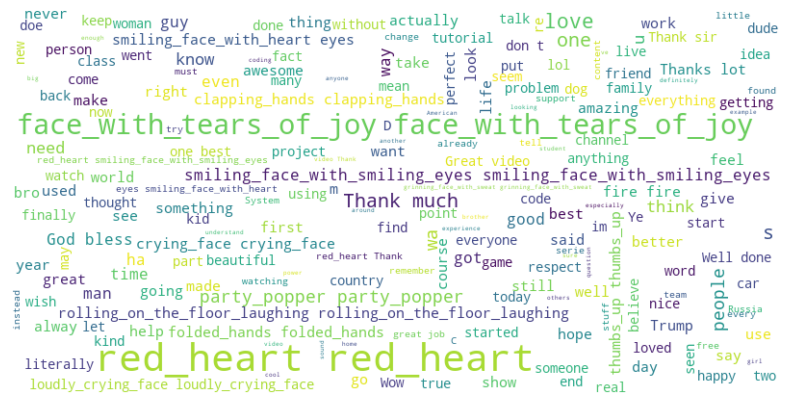

In [141]:
plot_word_cloud(df_cleaned[df_cleaned['label'] == 1]['text'])

##### Negative Comments

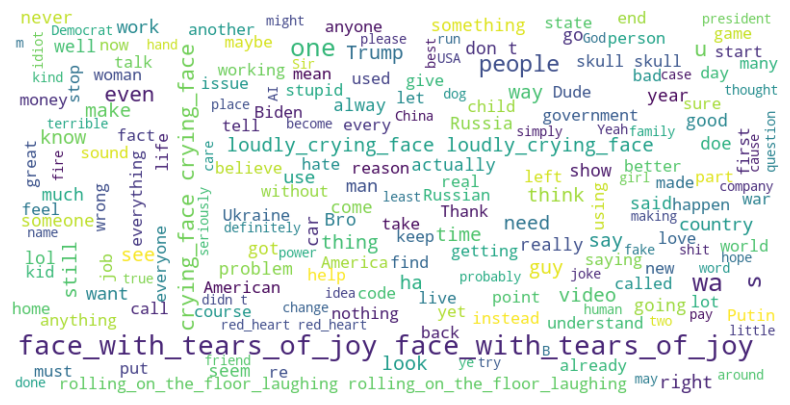

In [142]:
plot_word_cloud(df_cleaned[df_cleaned['label'] == -1]['text'])

##### Neutral Comments

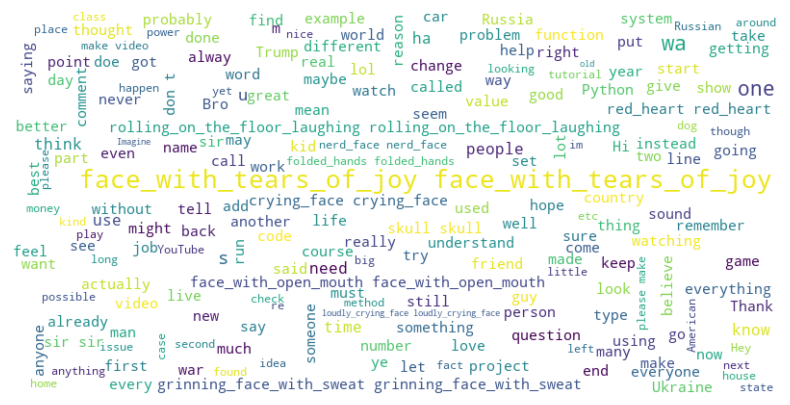

In [143]:
plot_word_cloud(df_cleaned[df_cleaned['label'] == 0]['text'])

#### Top N words by Sentiment

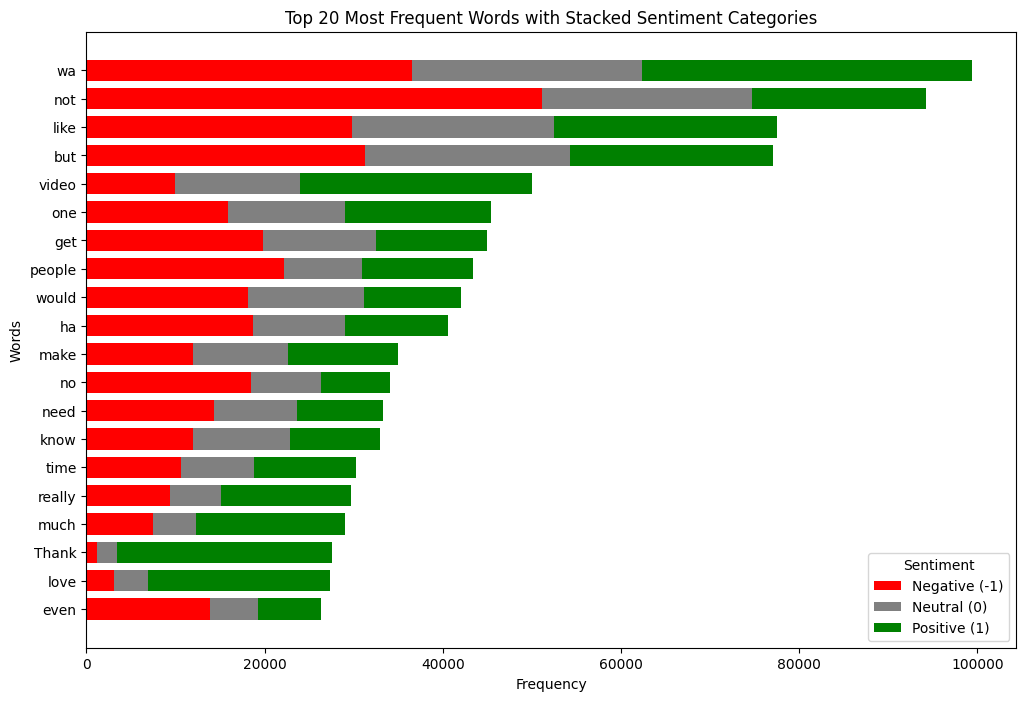

In [144]:
def plot_top_n_words_by_category(df, n=20, start=0):
    """Plot the top N most frequent words in the dataset with stacked hue based on sentiment category."""
    # Flatten all words in the content column and count their occurrences by category
    word_category_counts = {}

    for idx, row in df.iterrows():
        words = row['text'].split()
        category = row['label']  # Assuming 'category' column exists for -1, 0, 1 labels

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = { -1: 0, 0: 0, 1: 0 }  # Initialize counts for each sentiment category

            # Increment the count for the corresponding sentiment category
            word_category_counts[word][category] += 1

    # Get total counts across all categories for each word
    total_word_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}

    # Get the top N most frequent words across all categories
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
    top_words = [word for word, _ in most_common_words]

    # Prepare data for plotting
    word_labels = top_words
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]

    # Plot the stacked bar chart
    plt.figure(figsize=(12, 8))
    bar_width = 0.75

    # Plot negative, neutral, and positive counts in a stacked manner
    plt.barh(word_labels, negative_counts, color='red', label='Negative (-1)', height=bar_width)
    plt.barh(word_labels, neutral_counts, left=negative_counts, color='gray', label='Neutral (0)', height=bar_width)
    plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], color='green', label='Positive (1)', height=bar_width)

    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Frequent Words with Stacked Sentiment Categories')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()



plot_top_n_words_by_category(df_cleaned, n=20)


### Save preprocessed Data

In [145]:
# Save the cleaned DataFrame to a CSV file
df_cleaned[['text', 'label']].to_csv(r"data\youtube_comment_sentiment_cleaned.csv", index=False)